### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### DataLoader

In [5]:
input_path = '/home/nn_unet_for_anh/Dataset/inputData1T_5K.xlsx'
output_path = '/home/nn_unet_for_anh/Dataset/outputData1T_5K.xlsx'

In [6]:
class DOTDataset(Dataset):
    """
    Custom Dataset for Diffuse Optical Tomography (DOT) data
    Args:
        x_data (np.ndarray): Input measurement vectors.
        y_data (np.ndarray): Output absorption coefficient vectors.
    """
    def __init__(self, x_data, y_data):
        self.X = x_data
        self.Y = y_data

        # Raise error if number of input samples and output samples do not match.
        assert self.X.shape[0] == self.Y.shape[0], 'Mismatch in number of samples'

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieve one sample by index.
        Args:
            idx (int): Index of the sample.
        """
        x = torch.tensor(self.X[idx])
        y = torch.tensor(self.Y[idx])

        return x, y


def get_dataloaders(x_path, y_path, val_ratio=0.1, test_ratio=0.1):
    """
    Load DOT data from Excel files, normalize them, and split into train, validation, and test sets.

    Args:
        x_path (str): Path to the Excel file containing input.
        y_path (str): Path to the Excel file containing output.
        val_ratio (float): Fraction of the dataset to use for validation.
        test_ratio (float): Fraction of the dataset to use for testing.
    """
    # Load data from Excel and transpose to shape (N_samples, N_features)
    X_full = pd.read_excel(x_path, header=None).T.values.astype('float32')
    Y_full = pd.read_excel(y_path, header=None).T.values.astype('float32')

    # Normalize the input to range [0, 1]
    max_val_X = X_full.max()
    X_full = X_full / max_val_X

    # Normalize the output to range [0, 1]
    max_val_Y = Y_full.max()
    Y_full = Y_full / max_val_Y

    normalization_params = {
        'x_max': max_val_X,
        'y_max': max_val_Y
    }

    # Create a dataset
    dataset = DOTDataset(X_full, Y_full)

    # Split dataset into train, validation, and test sets. 
    total = len(dataset)
    val_size = int(total * val_ratio)
    test_size = int(total * test_ratio)
    train_size = total - val_size - test_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoader with full-batch loading
    train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)
    val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

    return train_loader, val_loader, test_loader, normalization_params

In [7]:
train_loader, val_loader, test_loader, norm_params = get_dataloaders(input_path, output_path)

for x_batch, y_batch in train_loader:
    print(x_batch.shape)    #expected: [4000, 240] for 1D
    print(y_batch.shape)    #expected: [4000, 1785] for 1D
    break

torch.Size([4000, 240])
torch.Size([4000, 1785])


### Backpropagation Neural Network (BPNN)

In [8]:
class BPNN(nn.Module):
    """
    Backpropagation Neural Network (BPNN) for DOT image reconstruction with one hidden layer.
    Args:
        input_dim (int): Dimensionality of the input vector. Default is 240.
        hidden_dim (int): Number of hidden units. Default is 656.
        output_dim (int): Dimensionality of the output vector. Default is 1785.
    """
    def __init__(self, input_dim=240, hidden_dim=656, output_dim=1785):
        super(BPNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Tanh()

    def forward(self, x):
        """ Forward pass of the BPNN. """
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)

        return x

### Training Loop

In [10]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-5, weight_decay=1e-8):
    """
    Train a neural network model using MSE loss and Adam optimizer.
    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        epochs (int): Number of training epochs. Default is 50.
        lr (float): Learning rate for the optimizer. Default is 1e-5.
        weight_decay (float): Weight decay (L2 regularization) for the optimizer. Default is 1e-8.
    Returns:
            - The trained model,
            - List of training losses per epoch,
            - List of validation losses per epoch.
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # ------ Training ---------
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # ------ Validation ---------
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                output = model(x_batch)
                loss = criterion(output, y_batch)
                
                val_loss += loss.item() * x_batch.size(0)

        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch+1) % 1000 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                print('Best model saved')

    print('Training Complete')
    return model, train_losses, val_losses


Epoch 1000/10000 | Train Loss: 0.007191 | Val Loss: 0.007288
Best model saved
Epoch 2000/10000 | Train Loss: 0.006707 | Val Loss: 0.006784
Best model saved
Epoch 3000/10000 | Train Loss: 0.006384 | Val Loss: 0.006460
Best model saved
Epoch 4000/10000 | Train Loss: 0.006275 | Val Loss: 0.006414
Best model saved
Epoch 5000/10000 | Train Loss: 0.006193 | Val Loss: 0.006180
Best model saved
Epoch 6000/10000 | Train Loss: 0.005996 | Val Loss: 0.006049
Best model saved
Epoch 7000/10000 | Train Loss: 0.005894 | Val Loss: 0.005956
Best model saved
Epoch 8000/10000 | Train Loss: 0.005863 | Val Loss: 0.005906
Best model saved
Epoch 9000/10000 | Train Loss: 0.005725 | Val Loss: 0.005787
Best model saved
Epoch 10000/10000 | Train Loss: 0.005657 | Val Loss: 0.005722
Best model saved
Training Complete


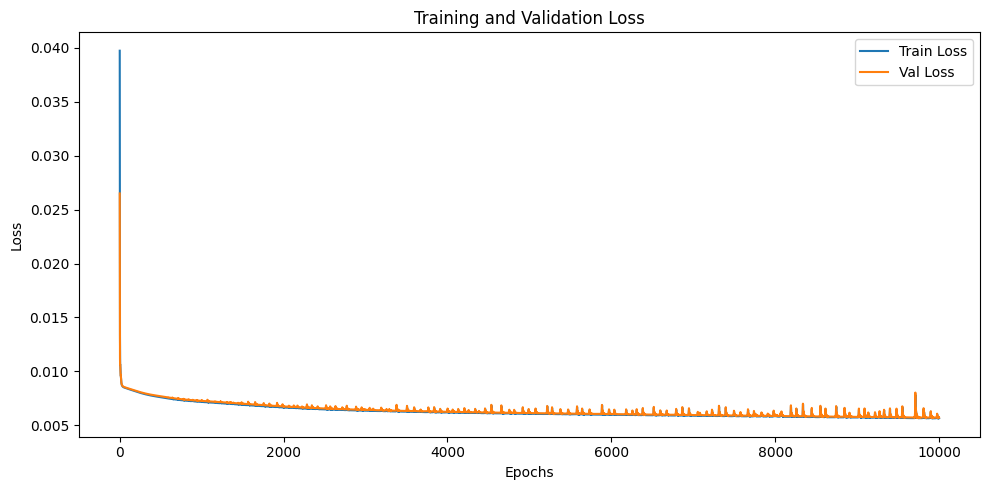

In [11]:
model = BPNN(input_dim=240, hidden_dim=656, output_dim=1785)
model, train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10000, lr=5e-4, weight_decay=0)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation

In [18]:
def _ssim_global(x: np.ndarray,
                 y: np.ndarray,
                 c1: float = 1e-4,
                 c2: float = 1e-4) -> float:
    """
    Global‑mean SSIM as
        (2 μ_x μ_y + c1)(2 σ_xy + c2)
    -----------------------------------
        (μ_x² + μ_y² + c1)(σ_x² + σ_y² + c2)

    • Works for 2‑D (H×W) or 3‑D (H×W×C) arrays.
    • For colour images each channel is scored
      independently and the mean is returned.
    """
    if x.ndim == 3:                      # H × W × C
        μ_x  = x.mean(axis=(0, 1))
        μ_y  = y.mean(axis=(0, 1))
        σ_x2 = x.var(axis=(0, 1))
        σ_y2 = y.var(axis=(0, 1))
        σ_xy = ((x - μ_x) * (y - μ_y)).mean(axis=(0, 1))
        ssim_c = ((2 * μ_x * μ_y + c1) * (2 * σ_xy + c2)) / \
                 ((μ_x**2 + μ_y**2 + c1) * (σ_x2 + σ_y2 + c2))
        return float(ssim_c.mean())      # average over channels
    else:                                # 1‑D or 2‑D
        μ_x  = x.mean()
        μ_y  = y.mean()
        σ_x2 = x.var()
        σ_y2 = y.var()
        σ_xy = ((x - μ_x) * (y - μ_y)).mean()
        return float(((2 * μ_x * μ_y + c1) * (2 * σ_xy + c2)) /
                     ((μ_x**2 + μ_y**2 + c1) * (σ_x2 + σ_y2 + c2)))

In [30]:
def compute_metrics(y_true, y_pred):
    """
    Compute quantitative evaluation metrics between predicted and ground truth images.
    Metrics include:
        - ABE (Absolute Bias Error)
        - MSE (custom Mean Squared Error variant)
        - MSE-S (standard Mean Squared Error)
        - PSNR (custom variant)
        - PSNR-S (standard variant)
        - SSIM (Structural Similarity Index)
    Args:
        y_true (torch.Tensor): Ground truth image tensor. Shape: (1, H, W) or (3, H, W).
        y_pred (torch.Tensor): Predicted image tensor. Shape: (1, H, W) or (3, H, W).
    Returns:
        dict: A dictionary containing the computed metric values.
    """
    y_true = y_true.detach().cpu().numpy().squeeze()
    y_pred = y_pred.detach().cpu().numpy().squeeze()

    if y_true.ndim == 3 and y_true.shape[0] == 3:
        y_true = np.moveaxis(y_true, 0, -1)
        y_pred = np.moveaxis(y_pred, 0, -1)

    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)

    #SSIM
    ssim = _ssim_global(y_true, y_pred, c1=1e-4, c2=1e-4)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    #ABE
    abe = np.mean(np.abs(y_true - y_pred))

    #MSE
    y_pred_mean = np.mean(y_pred)
    var = np.mean(np.abs(y_true - y_pred_mean))
    mse = abe**2 + var

    #MSE-S
    mse_s = np.mean(np.abs(y_true - y_pred)**2)

    #PSNR
    psnr = 10*np.log10((np.max(y_pred)**2)/mse)

    #PSNR-S
    psnr_s = 10*np.log10((np.max(y_pred)**2)/mse_s)


    return {
        'ABE': abe,
        'MSE': mse,
        'MSE-S': mse_s,
        'PSNR': psnr,
        'PSNR-S': psnr_s,
        'SSIM-G': ssim
        }

In [31]:
def evaluate_model_mean(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate a trained model on the test set and compute average performance metrics.
    The function prints the mean and standard deviation of each metric across the test set.

    Args:
        model (torch.nn.Module): Trained PyTorch model to be evaluated.
        test_loader (DataLoader): DataLoader containing test samples.
        device (str): Device to run inference on ('cuda' or 'cpu').
    """
    
    
    model = model.to(device)
    model.eval()

    all_metrics ={
        'ABE': [],
        'MSE': [],
        'MSE-S': [],
        'PSNR': [],
        'PSNR-S': [],
        'SSIM': []
    }

    with torch.no_grad():
      for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)

        for i in range(x_batch.size(0)):
          metrics = compute_metrics(y_batch[i], output[i])
          for key, value in metrics.items():
            all_metrics[key].append(value)

    for key, value in all_metrics.items():
      mean = np.mean(value)
      std = np.std(value)
      print(f'{key}: {mean:.4f} ± {std:.4f}')

In [32]:
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model_mean(model, test_loader)

ABE: 0.0256 ± 0.0088
MSE: 0.0317 ± 0.0119
MSE-S: 0.0061 ± 0.0055
PSNR: 6.9926 ± 2.6735
PSNR-S: 15.6140 ± 4.6719
SSIM-G: 0.5225 ± 0.1700


### Save the predictions

In [33]:
def save_predictions(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu',
                     y_true_path='y_true.xlsx', y_pred_path='y_pred.xlsx'):
    """
    Run the model on the test set and save ground truth and predicted outputs to Excel files.

    Args:
        model (torch.nn.Module): Trained PyTorch model for inference.
        test_loader (DataLoader): DataLoader containing test data.
        device (str): Device to perform inference on ('cuda' or 'cpu').
        y_true_path (str): File path to save ground truth outputs (.xlsx).
        y_pred_path (str): File path to save predicted outputs (.xlsx).
    """
    model = model.to(device)
    model.eval()
    
    all_y_true = []
    all_y_pred = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            preds = model(x_batch).cpu().numpy()
            y_true = y_batch.cpu().numpy()
            
            all_y_true.append(y_true)
            all_y_pred.append(preds)
        
    all_y_true = np.vstack(all_y_true)
    all_y_pred = np.vstack(all_y_pred)
    
    pd.DataFrame(all_y_true).T.to_excel(y_true_path, index=False, header=False)
    pd.DataFrame(all_y_pred).T.to_excel(y_pred_path, index=False, header=False)

In [35]:
model.load_state_dict(torch.load("best_model.pth"))
save_predictions(model, test_loader)